### Overview

In this project, you will learn about a complete modular implementation to analyze stock market data. It aims to get stocks using APIs and web scraping, process and visualize them and gather insights. It combines several tools and techniques to deliver an easy experience for anyone who plans to check stock trends, readable news and critical financial statistics.

##### 1. Fetch Stock Data Using an API

In the subsequent portion of the code, we request stock data through the Alpha Vantage API, such as opening price, closing price, highest price, lowest price, and trading volume at varying time intervals. We make an API call with the stock symbol (for example, "AAPL" for Apple) and time interval (for example, "5 minutes"). The data received is returned as a JSON file through the API containing stock price history. We then parse this JSON into a pandas DataFrame, a table-like structure that makes processing and analysis easier. This is like asking a competent service ***Tell me all about this stock*** and then putting the answer to a nice spreadsheet to utilize later.

In [8]:
import requests
import pandas as pd

# Fetch stock data using Alpha Vantage API
def fetch_stock_data(symbol, interval="5min"):
    api_url = "https://www.alphavantage.co/query"
    api_key = "YOUR_API_KEY"  # Replace with your Alpha Vantage API key
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": interval,
        "apikey": api_key
    }

    # Send a GET request to the API
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        data = response.json()
        time_series = data.get(f"Time Series ({interval})", {})
        
        if not time_series:
            print(f"No data found for {symbol}")
            return None
        
        # Convert the time series data to a DataFrame
        df = pd.DataFrame.from_dict(time_series, orient="index")
        df.columns = ["Open", "High", "Low", "Close", "Volume"]
        df.index = pd.to_datetime(df.index)  # Convert index to datetime
        df = df.sort_index()  # Sort data by time
        return df
    else:
        print(f"API request failed with status code {response.status_code}")
        return None

# Test the function
if __name__ == "__main__":
    symbol = "AAPL"
    stock_data = fetch_stock_data(symbol)
    if stock_data is not None:
        print(stock_data.head())
        stock_data.to_csv(f"{symbol}_stock_data.csv")


                         Open      High       Low     Close  Volume
2025-01-03 11:40:00  243.8800  244.0486  243.7700  243.7950  326833
2025-01-03 11:45:00  243.7850  243.7943  243.6150  243.6700  211254
2025-01-03 11:50:00  243.7100  243.8600  243.5900  243.7187  296149
2025-01-03 11:55:00  243.7100  243.7500  243.3000  243.3201  187886
2025-01-03 12:00:00  243.3400  243.5190  243.1416  243.1577  278354


##### 2. Visualize Stock Data

We have used matplotlib to plot a line chart of how the stock’s price changes over time. We extract the closing prices from the DataFrame and plot them against their timestamps. This kind of summary visualization lets us know if prices for stocks are up, down, or flat. The chart brings the numbers to life, so you can see how the stock performed without needing to sift through raw data.

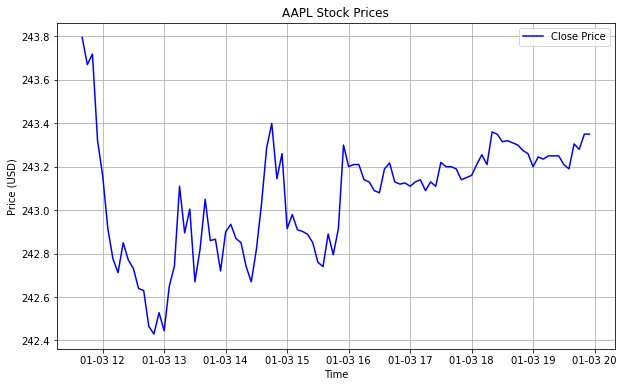

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot stock data
def plot_stock_data(df, symbol):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df["Close"].astype(float), label="Close Price", color="blue")
    plt.title(f"{symbol} Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

# Test the function
if __name__ == "__main__":
    # Load data from a CSV file for testing
    df = pd.read_csv("AAPL_stock_data.csv", index_col=0, parse_dates=True)
    plot_stock_data(df, "AAPL")


##### 3. Scrape News Headlines

This section employs ***Selenium WebDriver*** to control a browser (say, Chrome) and direct it to the Yahoo Finance news site for the assigned stock go here. Selenium enables interaction with javascript-loaded content. Using CSS selectors, we tell the browser to select all the news headlines and links on the page. We then serialize our headline and link into a pandas DataFrame which yields a concise summary of news articles relating to the stock. This is akin to asking Yahoo Finance, ***What’s the latest buzz on this stock?*** and formatting their response in clear, organized terms.

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import pandas as pd

# Path to ChromeDriver
CHROMEDRIVER_PATH = # Update with your path

# Function to scrape stock news
def scrape_stock_news(symbol):
    url = f"https://finance.yahoo.com/quote/{symbol}/news"

    # Set up Selenium WebDriver
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(service=Service(CHROMEDRIVER_PATH), options=options)

    try:
        # Open the webpage
        driver.get(url)
        # Find all news articles
        articles = driver.find_elements(By.CSS_SELECTOR, "h3 a")

        # Extract headlines and links
        news = []
        for article in articles:
            title = article.text
            link = article.get_attribute("href")
            news.append({"Headline": title, "Link": link})

        driver.quit()  # Close the browser
        return pd.DataFrame(news)
    except Exception as e:
        print("Error fetching news:", e)
        driver.quit()
        return None

# Test the function
if __name__ == "__main__":
    symbol = "AAPL"
    news = scrape_stock_news(symbol)
    if news is not None:
        print(news.head())
        news.to_csv(f"{symbol}_news.csv", index=False)


  Headline                                  Link
0                         https://www.yahoo.com/
1               https://www.yahoo.com/lifestyle/
2           https://www.yahoo.com/entertainment/
3                     https://finance.yahoo.com/
4                      https://sports.yahoo.com/


##### 4. Scrape Key Financial Statistics

Here we again use Selenium to visit Yahoo Finance, but this time we navigate to the stock's Key Statistics page. Here, we articulate financial metrics such as profit margins, total revenue and debt-equity ratios. Selenium, simulating actions on the page, which allows us to find and scrape rows of the statistics table. These metrics provide deeper insight into the company’s financial health and can help users make informed decisions about investing in the stock. It’s similar to looking at a company’s report card to gauge its performance.

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Path to ChromeDriver
CHROMEDRIVER_PATH =  # Update with your path

# Function to scrape stock statistics
def scrape_stock_statistics(symbol):
    url = f"https://finance.yahoo.com/quote/{symbol}/key-statistics"

    # Set up Selenium WebDriver
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(service=Service(CHROMEDRIVER_PATH), options=options)

    try:
        # Open the webpage
        driver.get(url)
        # Find all rows in the statistics table
        rows = driver.find_elements(By.CSS_SELECTOR, "table tbody tr")

        # Extract key-value pairs
        stats = {}
        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) == 2:
                key = cells[0].text
                value = cells[1].text
                stats[key] = value

        driver.quit()  # Close the browser
        return stats
    except Exception as e:
        print("Error fetching statistics:", e)
        driver.quit()
        return None

# Test the function
if __name__ == "__main__":
    symbol = "AAPL"
    stats = scrape_stock_statistics(symbol)
    if stats:
        for key, value in stats.items():
            print(f"{key}: {value}")


Fiscal Year Ends: 9/28/2024
Most Recent Quarter (mrq): 9/28/2024
Profit Margin: 23.97%
Operating Margin (ttm): 31.17%
Return on Assets (ttm): 21.46%
Return on Equity (ttm): 157.41%
Revenue (ttm): 391.03B
Revenue Per Share (ttm): 25.49
Quarterly Revenue Growth (yoy): 6.10%
Gross Profit (ttm): --
EBITDA: 134.66B
Net Income Avi to Common (ttm): 93.74B
Diluted EPS (ttm): 6.08
Quarterly Earnings Growth (yoy): -35.80%
Total Cash (mrq): 65.17B
Total Cash Per Share (mrq): 4.31
Total Debt (mrq): 119.06B
Total Debt/Equity (mrq): 209.06%
Current Ratio (mrq): 0.87
Book Value Per Share (mrq): 3.77
Operating Cash Flow (ttm): 118.25B
Levered Free Cash Flow (ttm): 110.85B
Beta (5Y Monthly): 1.24
52 Week Range 3: 31.15%
S&P 500 52-Week Change 3: 24.75%
52 Week High 3: 260.10
52 Week Low 3: 164.08
50-Day Moving Average 3: 237.90
200-Day Moving Average 3: 214.10
Avg Vol (3 month) 3: 44.01M
Avg Vol (10 day) 3: 51.3M
Shares Outstanding 5: 15.12B
Implied Shares Outstanding 6: 15.15B
Float 8: 15.09B
% Held b

##### 5. Organizing Data

This code organizes stock statistics into a readable table, saves them as a CSV file, and displays them in the console. It converts a dictionary of metrics (e.g., Apple's financial stats) into a pandas DataFrame with "Metric" and "Value" columns, saves it as AAPL_key_statistics.csv, and prints the data for quick viewing.

In [7]:
def format_and_save_statistics(stats, symbol):
    # Convert the statistics dictionary to a DataFrame
    df = pd.DataFrame(list(stats.items()), columns=["Metric", "Value"])
    
    # Save to a CSV file
    csv_filename = f"{symbol}_key_statistics.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Key statistics saved to {csv_filename}")
    
    # Print the DataFrame in a table format
    print("\nFormatted Key Statistics:")
    print(df.to_string(index=False))

# Example usage with your statistics output
statistics = {
    "Fiscal Year Ends": "9/28/2024",
    "Most Recent Quarter (mrq)": "9/28/2024",
    "Profit Margin": "23.97%",
    "Operating Margin (ttm)": "31.17%",
    "Return on Assets (ttm)": "21.46%",
    "Return on Equity (ttm)": "157.41%",
    "Revenue (ttm)": "391.03B",
    "Revenue Per Share (ttm)": "25.49",
    "Quarterly Revenue Growth (yoy)": "6.10%",
    "Gross Profit (ttm)": "--",
    "EBITDA": "134.66B",
    "Net Income Avi to Common (ttm)": "93.74B",
    "Diluted EPS (ttm)": "6.08",
    "Quarterly Earnings Growth (yoy)": "-35.80%",
    "Total Cash (mrq)": "65.17B",
    "Total Cash Per Share (mrq)": "4.31",
    "Total Debt (mrq)": "119.06B",
    "Total Debt/Equity (mrq)": "209.06%",
    "Current Ratio (mrq)": "0.87",
    "Book Value Per Share (mrq)": "3.77",
    "Operating Cash Flow (ttm)": "118.25B",
    "Levered Free Cash Flow (ttm)": "110.85B",
    "Beta (5Y Monthly)": "1.24",
    "52 Week Range": "31.15%",
    "S&P 500 52-Week Change": "24.75%",
    "52 Week High": "260.10",
    "52 Week Low": "164.08",
    "50-Day Moving Average": "237.90",
    "200-Day Moving Average": "214.10",
    "Avg Vol (3 month)": "44.01M",
    "Avg Vol (10 day)": "51.3M",
    "Shares Outstanding": "15.12B",
    "Implied Shares Outstanding": "15.15B",
    "Float": "15.09B",
    "% Held by Insiders": "2.06%",
    "% Held by Institutions": "61.92%",
    "Shares Short (12/13/2024)": "156.46M",
    "Short Ratio (12/13/2024)": "3.67",
    "Short % of Float (12/13/2024)": "1.04%",
    "Short % of Shares Outstanding (12/13/2024)": "1.04%",
    "Shares Short (prior month 11/15/2024)": "141.04M",
    "Forward Annual Dividend Rate": "1",
    "Forward Annual Dividend Yield": "0.41%",
    "Trailing Annual Dividend Rate": "0.98",
    "Trailing Annual Dividend Yield": "0.40%",
    "5 Year Average Dividend Yield": "0.61",
    "Payout Ratio": "16.12%",
    "Dividend Date": "11/14/2024",
    "Ex-Dividend Date": "11/8/2024",
    "Last Split Factor": "4:1",
    "Last Split Date": "8/31/2020"
}

# Format and save the statistics
format_and_save_statistics(statistics, "AAPL")

Key statistics saved to AAPL_key_statistics.csv

Formatted Key Statistics:
                                    Metric      Value
                          Fiscal Year Ends  9/28/2024
                 Most Recent Quarter (mrq)  9/28/2024
                             Profit Margin     23.97%
                    Operating Margin (ttm)     31.17%
                    Return on Assets (ttm)     21.46%
                    Return on Equity (ttm)    157.41%
                             Revenue (ttm)    391.03B
                   Revenue Per Share (ttm)      25.49
            Quarterly Revenue Growth (yoy)      6.10%
                        Gross Profit (ttm)         --
                                    EBITDA    134.66B
            Net Income Avi to Common (ttm)     93.74B
                         Diluted EPS (ttm)       6.08
           Quarterly Earnings Growth (yoy)    -35.80%
                          Total Cash (mrq)     65.17B
                Total Cash Per Share (mrq)       4.31
       